## Tags Distribution

This notebook plots distribution of image tags for a given project.

**Input**:
- Source project

**Output**:
- Tag distribution plot

## Configuration

Edit the following settings for your own case

In [1]:
%matplotlib inline

In [2]:
import supervisely_lib as sly
import os
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [3]:
team_name = "jupyter_tutorials"
workspace_name = "cookbook"
project_name = "lemons_annotated_01"

# Obtain server address and your api_token from environment variables
# Edit those values if you run this notebook on your own PC
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

In [4]:
# Initialize API object
api = sly.Api(address, token)

## Verify input values

Test that context (team / workspace / project) exists

In [5]:
# Get IDs of team, workspace and project by names

team = api.team.get_info_by_name(team_name)
if team is None:
    raise RuntimeError("Team {!r} not found".format(team_name))

workspace = api.workspace.get_info_by_name(team.id, workspace_name)
if workspace is None:
    raise RuntimeError("Workspace {!r} not found".format(workspace_name))
    
project = api.project.get_info_by_name(workspace.id, project_name)
if project is None:
    raise RuntimeError("Project {!r} not found".format(project_name))
    
print("Team: id={}, name={}".format(team.id, team.name))
print("Workspace: id={}, name={}".format(workspace.id, workspace.name))
print("Project: id={}, name={}".format(project.id, project.name))

Team: id=30, name=jupyter_tutorials
Workspace: id=76, name=cookbook
Project: id=1294, name=lemons_annotated_01


## Get Source ProjectMeta

In [6]:
meta_json = api.project.get_meta(project.id)
meta = sly.ProjectMeta.from_json(meta_json)
print("Source ProjectMeta: \n", meta)

Source ProjectMeta: 
 ProjectMeta:
Object Classes
+-------+--------+----------------+
|  Name | Shape  |     Color      |
+-------+--------+----------------+
|  kiwi | Bitmap |  [255, 0, 0]   |
| lemon | Bitmap | [81, 198, 170] |
+-------+--------+----------------+
Image Tags
+-------+------------+-----------------+
|  Name | Value type | Possible values |
+-------+------------+-----------------+
| train |    none    |       None      |
|  val  |    none    |       None      |
+-------+------------+-----------------+
Object Tags
+------+------------+-----------------+
| Name | Value type | Possible values |
+------+------------+-----------------+
+------+------------+-----------------+



In [7]:
tags_counter = defaultdict(int)
tags_counter_raw_json = defaultdict(int)

for dataset in api.dataset.get_list(project.id):
    print('Dataset: {}'.format(dataset.name), flush=True)
    images = api.image.get_list(dataset.id)
    
    with tqdm(total=len(images), desc="Process annotations") as progress_bar:
        for batch in sly.batched(images):
            image_ids = [image_info.id for image_info in batch]
            
            ann_infos = api.annotation.download_batch(dataset.id, image_ids)
            for ann_info in ann_infos:
                ann_json = ann_info.annotation
                ann = sly.Annotation.from_json(ann_json, meta)
                
                # count tags using SDK
                for tag in ann.img_tags:
                    tags_counter[tag.meta.name] += 1 

                # count tags using raw JSON annotation
                for tag in ann_json["tags"]:
                    name = tag if (type(tag) is str) else tag["name"]
                    tags_counter_raw_json[name] += 1 
                
            progress_bar.update(len(batch))

Dataset: ds1


Process annotations: 100%|██████████| 6/6 [00:00<00:00, 151.76it/s]


## Distribution (using SDK)

[('train', 4), ('val', 2)]


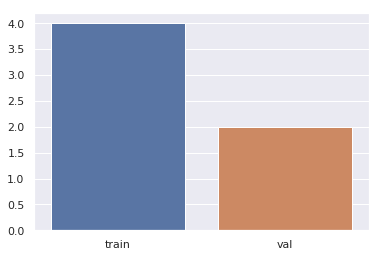

In [8]:
sorted_list = sorted(tags_counter.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_list)
x = [item[0] for item in sorted_list]
y = [item[1] for item in sorted_list]
ax = sns.barplot(x=x, y=y)

## Distribution (using raw JSON data - for debug purposes)

[('train', 4), ('val', 2)]


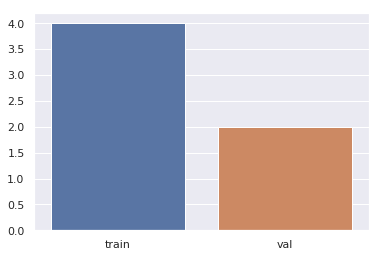

In [9]:
sorted_list = sorted(tags_counter_raw_json.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_list)
x = [item[0] for item in sorted_list]
y = [item[1] for item in sorted_list]
ax = sns.barplot(x=x, y=y)

# Done!